In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from prophet import Prophet
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
df_homes_forecast = pd.read_csv("Resources\Metro_homes.csv")
df_homes_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416926 entries, 0 to 416925
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   period_begin                    416926 non-null  object 
 1   period_end                      416926 non-null  object 
 2   parent_metro_region_metro_code  416926 non-null  int64  
 3   parent_metro_region             416926 non-null  object 
 4   state_code                      416926 non-null  object 
 5   property_type_id                416926 non-null  int64  
 6   property_type                   416926 non-null  object 
 7   median_sale_price               416382 non-null  float64
 8   median_list_price               388970 non-null  float64
 9   median_ppsf                     412248 non-null  float64
 10  median_list_ppsf                386245 non-null  float64
 11  homes_sold                      416386 non-null  float64
 12  pending_sales   

In [3]:
df_homes_forecast['period_end'] = pd.to_datetime(df_homes_forecast['period_end'])
df_homes_forecast['period_begin'] = pd.to_datetime(df_homes_forecast['period_begin'])
df_homes_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416926 entries, 0 to 416925
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   period_begin                    416926 non-null  datetime64[ns]
 1   period_end                      416926 non-null  datetime64[ns]
 2   parent_metro_region_metro_code  416926 non-null  int64         
 3   parent_metro_region             416926 non-null  object        
 4   state_code                      416926 non-null  object        
 5   property_type_id                416926 non-null  int64         
 6   property_type                   416926 non-null  object        
 7   median_sale_price               416382 non-null  float64       
 8   median_list_price               388970 non-null  float64       
 9   median_ppsf                     412248 non-null  float64       
 10  median_list_ppsf                386245 non-null  float64

In [4]:
df_homes_colab = df_homes_forecast.loc[df_homes_forecast['property_type'] != 'All Residential']
df_homes_colab
# sfr_df=df_homes_forecast['period_begin ',],

,period_begin,period_end,parent_metro_region_metro_code,parent_metro_region,state_code,property_type_id,property_type,median_sale_price,median_list_price,median_ppsf,median_list_ppsf,homes_sold,pending_sales,new_listings,inventory,months_of_supply,median_dom,price_drops
0,2016-07-01,2016-07-31,15660,"Calhoun, GA",GA,13,Townhouse,166900.0,122900.0,95.535203,79.339451,2.0,NaN,2.0,6.0,3.0,133.0,0.166667
1,2022-08-01,2022-08-31,33740,"Monroe, LA",LA,6,Single Family Residential,210000.0,215000.0,117.937595,113.065034,156.0,125.0,148.0,312.0,2.0,20.0,0.362179
2,2020-02-01,2020-02-29,39740,"Reading, PA",PA,4,Multi-Family (2-4 Unit),103250.0,129900.0,49.502539,56.662269,10.0,12.0,27.0,69.0,6.9,63.0,0.115942
3,2018-07-01,2018-07-31,37460,"Panama City, FL",FL,13,Townhouse,174700.0,196500.0,124.080882,137.240526,25.0,20.0,53.0,156.0,6.2,94.0,NaN
4,2020-09-01,2020-09-30,15420,"Burley, ID",ID,6,Single Family Residential,207250.0,207500.0,122.710623,129.365592,40.0,23.0,32.0,103.0,2.6,84.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416920,2021-08-01,2021-08-31,43740,"Somerset, PA",PA,3,Condo/Co-op,276000.0,327000.0,215.527025,231.182796,6.0,4.0,2.0,9.0,1.5,75.0,0.222222
416922,2018-10-01,2018-10-31,28140,"Kansas City, MO",MO,4,Multi-Family (2-4 Unit),170000.0,160000.0,52.623458,68.717277,51.0,NaN,72.0,NaN,2.4,34.0,0.130081
416923,2018-05-01,2018-05-31,20100,"Dover, DE",DE,13,Townhouse,177750.0,180000.0,103.021978,97.267980,24.0,19.0,42.0,89.0,3.7,39.0,0.269663
416924,2017-10-01,2017-10-31,23844,"Gary, IN",IN,13,Townhouse,161389.0,168260.0,110.892857,109.829060,77.0,47.0,99.0,353.0,4.6,73.0,NaN


(0.0, 481616.0)

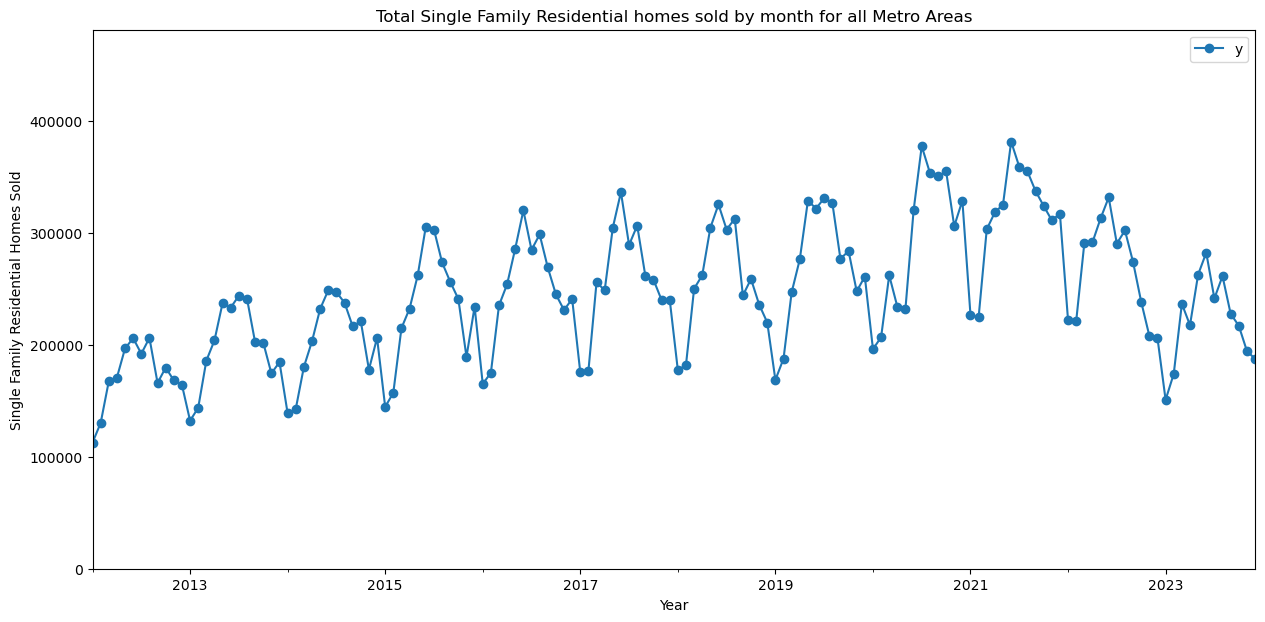

In [5]:
df_homes_srf = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Single Family Residential']
df_homes_srf1 = df_homes_srf[['period_begin','homes_sold']].rename(columns={'period_begin':'ds','homes_sold':'y'}).sort_values(by='ds').dropna()
df_homes_srf_sum=df_homes_srf1.groupby('ds')['y'].agg(['sum']).rename(columns={'sum':'y'})

df_homes_srf_sum.plot(marker="o", figsize=(15,7))
plt.title("Total Single Family Residential homes sold by month for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Single Family Residential Homes Sold")
#plt.xlim(-0.25, 0.25)
plt.ylim(0, max(df_homes_srf_sum["y"])+100000)

In [6]:
prophet_srf=df_homes_srf_sum.reset_index()
prophet_srf

,ds,y
0,2012-01-01,112719.0
1,2012-02-01,130198.0
2,2012-03-01,167492.0
3,2012-04-01,170803.0
4,2012-05-01,196881.0
...,...,...
139,2023-08-01,261437.0
140,2023-09-01,227835.0
141,2023-10-01,217136.0
142,2023-11-01,194587.0


In [7]:
m1 = Prophet()
m1.fit(prophet_srf)

20:05:46 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future_srf = m1.make_future_dataframe(periods=12, freq='M')
future_srf

,ds
0,2012-01-01
1,2012-02-01
2,2012-03-01
3,2012-04-01
4,2012-05-01
...,...
151,2024-07-31
152,2024-08-31
153,2024-09-30
154,2024-10-31


In [10]:
forecast_srf = m1.predict(future_srf)
forecast_srf.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
144,2023-12-31,219303.274323,125081.191079,177264.886772,219303.274323,219303.274323,-69020.206004,-69020.206004,-69020.206004,-69020.206004,-69020.206004,-69020.206004,0.0,0.0,0.0,150283.068319
145,2024-01-31,216684.639601,132187.123828,182262.874446,216625.418703,216759.949878,-58276.399439,-58276.399439,-58276.399439,-58276.399439,-58276.399439,-58276.399439,0.0,0.0,0.0,158408.240162
146,2024-02-29,214234.949054,171414.682118,222682.963363,214070.429548,214416.261089,-17563.672229,-17563.672229,-17563.672229,-17563.672229,-17563.672229,-17563.672229,0.0,0.0,0.0,196671.276825
147,2024-03-31,211616.314332,177363.053449,229529.339867,211294.600731,211957.679292,-7442.072234,-7442.072234,-7442.072234,-7442.072234,-7442.072234,-7442.072234,0.0,0.0,0.0,204174.242098
148,2024-04-30,209082.151698,223364.607200,274535.903783,208586.546670,209608.851137,39187.784053,39187.784053,39187.784053,39187.784053,39187.784053,39187.784053,0.0,0.0,0.0,248269.935751
149,2024-05-31,206463.516976,232164.331073,284240.316931,205773.902955,207183.209609,51805.641234,51805.641234,51805.641234,51805.641234,51805.641234,51805.641234,0.0,0.0,0.0,258269.158209
150,2024-06-30,203929.354341,213957.865913,264372.462660,203002.072438,204862.119282,36846.166724,36846.166724,36846.166724,36846.166724,36846.166724,36846.166724,0.0,0.0,0.0,240775.521065
151,2024-07-31,201310.719619,218827.886142,271888.772555,200133.215369,202494.097694,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,0.0,0.0,0.0,244110.126711
152,2024-08-31,198692.084897,184362.983944,234610.094935,197280.405765,200142.678272,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,0.0,0.0,0.0,209947.335124
153,2024-09-30,196157.922263,180842.635991,230446.157285,194459.699614,197851.835488,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,0.0,0.0,0.0,205484.480508


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(0.0, 481616.0)

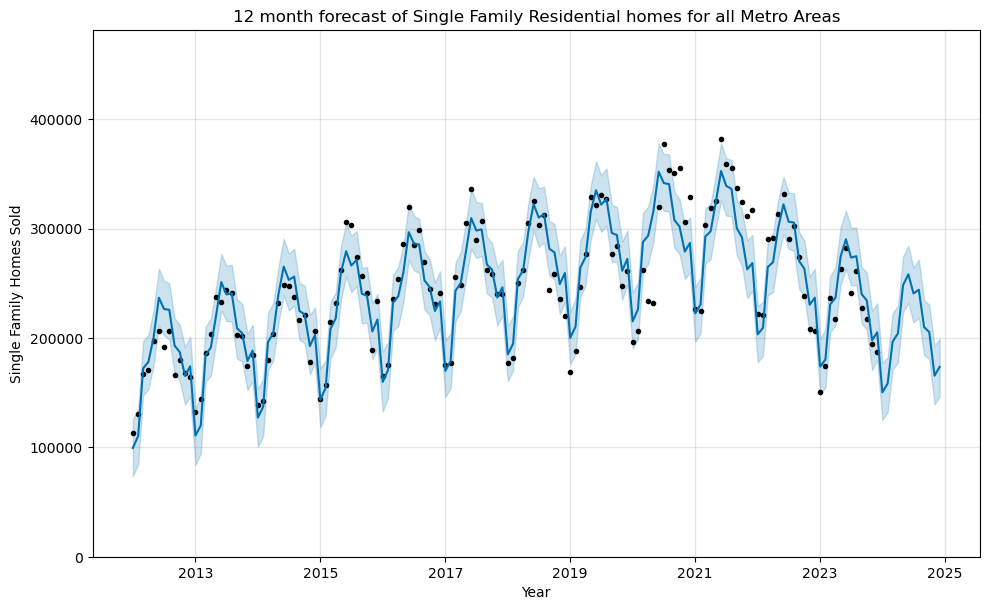

In [11]:
m1.plot(forecast_srf);
plt.title("12 month forecast of Single Family Residential homes for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Single Family Homes Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(df_homes_srf_sum["y"])+100000)

In [12]:
forecast_srf[['ds','yhat','yhat_lower','yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2012-01-01,99483.774916,73565.281962,126231.196829
1,2012-02-01,110408.465253,84518.023743,134991.445437
2,2012-03-01,172188.122910,147636.076837,197216.487367
3,2012-04-01,178165.110144,153344.669248,202783.058304
4,2012-05-01,200314.964135,174661.341407,225782.888826
...,...,...,...,...
151,2024-07-31,244110.126711,218827.886142,271888.772555
152,2024-08-31,209947.335124,184362.983944,234610.094935
153,2024-09-30,205484.480508,180842.635991,230446.157285
154,2024-10-31,165548.070708,139230.806188,193028.418663


In [13]:
forecast_srf=forecast_srf.set_index('ds')


In [14]:
forecast_srf

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2012-01-01,174368.364336,73565.281962,126231.196829,174368.364336,174368.364336,-74884.589420,-74884.589420,-74884.589420,-74884.589420,-74884.589420,-74884.589420,0.0,0.0,0.0,99483.774916
2012-02-01,175659.190365,84518.023743,134991.445437,175659.190365,175659.190365,-65250.725111,-65250.725111,-65250.725111,-65250.725111,-65250.725111,-65250.725111,0.0,0.0,0.0,110408.465253
2012-03-01,176866.737295,147636.076837,197216.487367,176866.737295,176866.737295,-4678.614385,-4678.614385,-4678.614385,-4678.614385,-4678.614385,-4678.614385,0.0,0.0,0.0,172188.122910
2012-04-01,178157.563323,153344.669248,202783.058304,178157.563323,178157.563323,7.546820,7.546820,7.546820,7.546820,7.546820,7.546820,0.0,0.0,0.0,178165.110144
2012-05-01,179406.749803,174661.341407,225782.888826,179406.749803,179406.749803,20908.214333,20908.214333,20908.214333,20908.214333,20908.214333,20908.214333,0.0,0.0,0.0,200314.964135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,201310.719619,218827.886142,271888.772555,200133.215369,202494.097694,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,0.0,0.0,0.0,244110.126711
2024-08-31,198692.084897,184362.983944,234610.094935,197280.405765,200142.678272,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,0.0,0.0,0.0,209947.335124
2024-09-30,196157.922263,180842.635991,230446.157285,194459.699614,197851.835488,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,0.0,0.0,0.0,205484.480508


(0.0, 378088.71880195563)

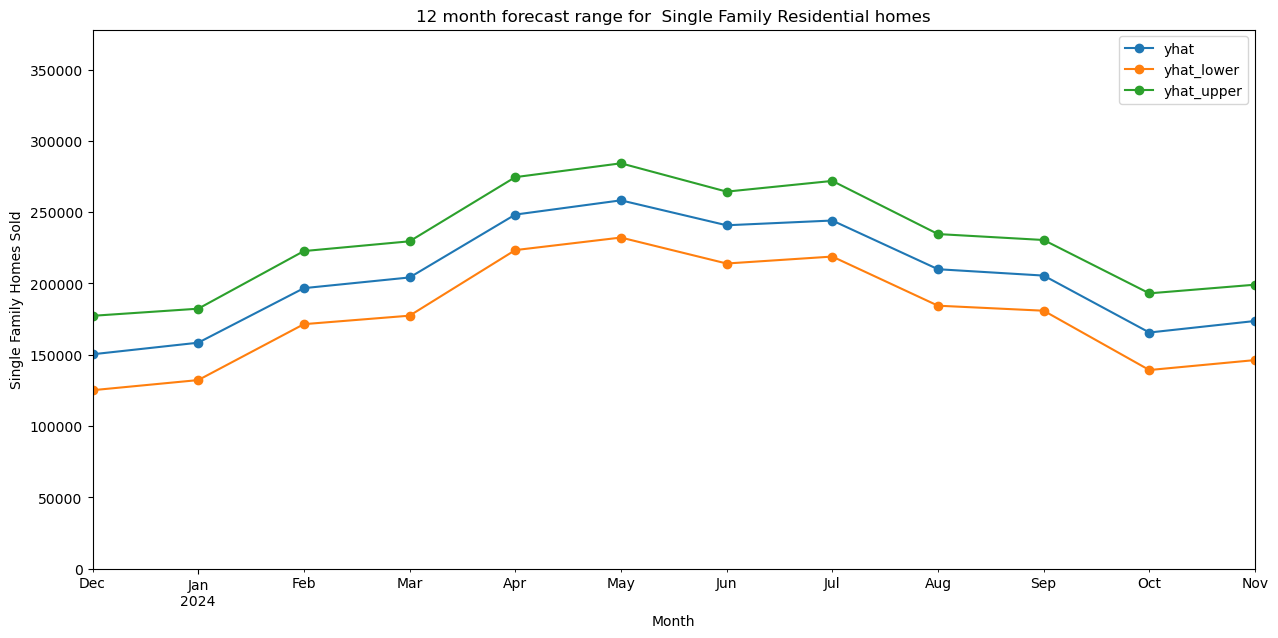

In [15]:
forecast_srf[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot(marker="o", figsize=(15,7))
plt.title("12 month forecast range for  Single Family Residential homes")
plt.xlabel("Month")
plt.ylabel("Single Family Homes Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(forecast_srf['yhat_upper']))

In [16]:
forecast_srf = forecast_srf.reset_index()
forecast_srf

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,174368.364336,73565.281962,126231.196829,174368.364336,174368.364336,-74884.589420,-74884.589420,-74884.589420,-74884.589420,-74884.589420,-74884.589420,0.0,0.0,0.0,99483.774916
1,2012-02-01,175659.190365,84518.023743,134991.445437,175659.190365,175659.190365,-65250.725111,-65250.725111,-65250.725111,-65250.725111,-65250.725111,-65250.725111,0.0,0.0,0.0,110408.465253
2,2012-03-01,176866.737295,147636.076837,197216.487367,176866.737295,176866.737295,-4678.614385,-4678.614385,-4678.614385,-4678.614385,-4678.614385,-4678.614385,0.0,0.0,0.0,172188.122910
3,2012-04-01,178157.563323,153344.669248,202783.058304,178157.563323,178157.563323,7.546820,7.546820,7.546820,7.546820,7.546820,7.546820,0.0,0.0,0.0,178165.110144
4,2012-05-01,179406.749803,174661.341407,225782.888826,179406.749803,179406.749803,20908.214333,20908.214333,20908.214333,20908.214333,20908.214333,20908.214333,0.0,0.0,0.0,200314.964135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2024-07-31,201310.719619,218827.886142,271888.772555,200133.215369,202494.097694,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,42799.407092,0.0,0.0,0.0,244110.126711
152,2024-08-31,198692.084897,184362.983944,234610.094935,197280.405765,200142.678272,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,11255.250227,0.0,0.0,0.0,209947.335124
153,2024-09-30,196157.922263,180842.635991,230446.157285,194459.699614,197851.835488,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,9326.558245,0.0,0.0,0.0,205484.480508
154,2024-10-31,193539.287541,139230.806188,193028.418663,191557.754550,195435.800905,-27991.216833,-27991.216833,-27991.216833,-27991.216833,-27991.216833,-27991.216833,0.0,0.0,0.0,165548.070708


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

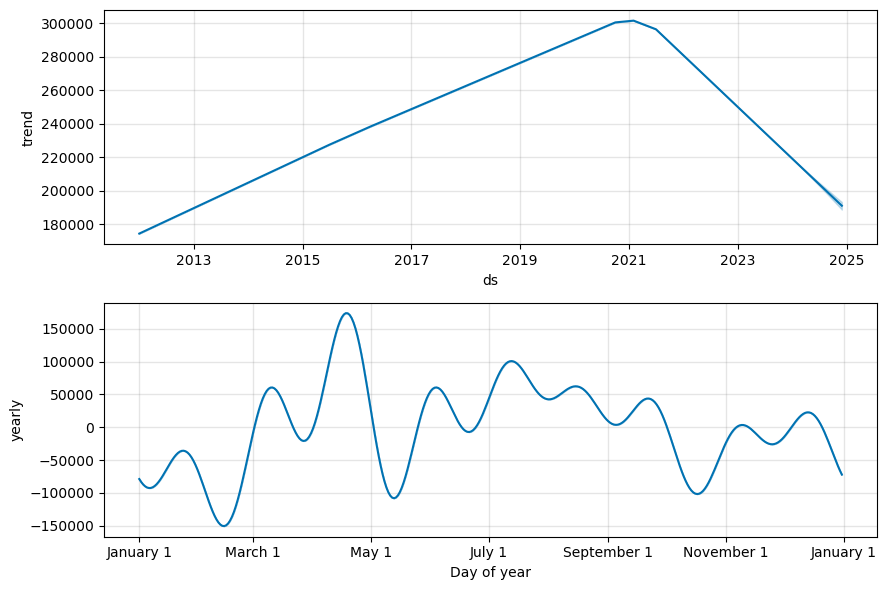

In [17]:
fig1=m1.plot_components(forecast_srf)
#plt.title

Text(0, 0.5, 'Condo/Co-op Sold')

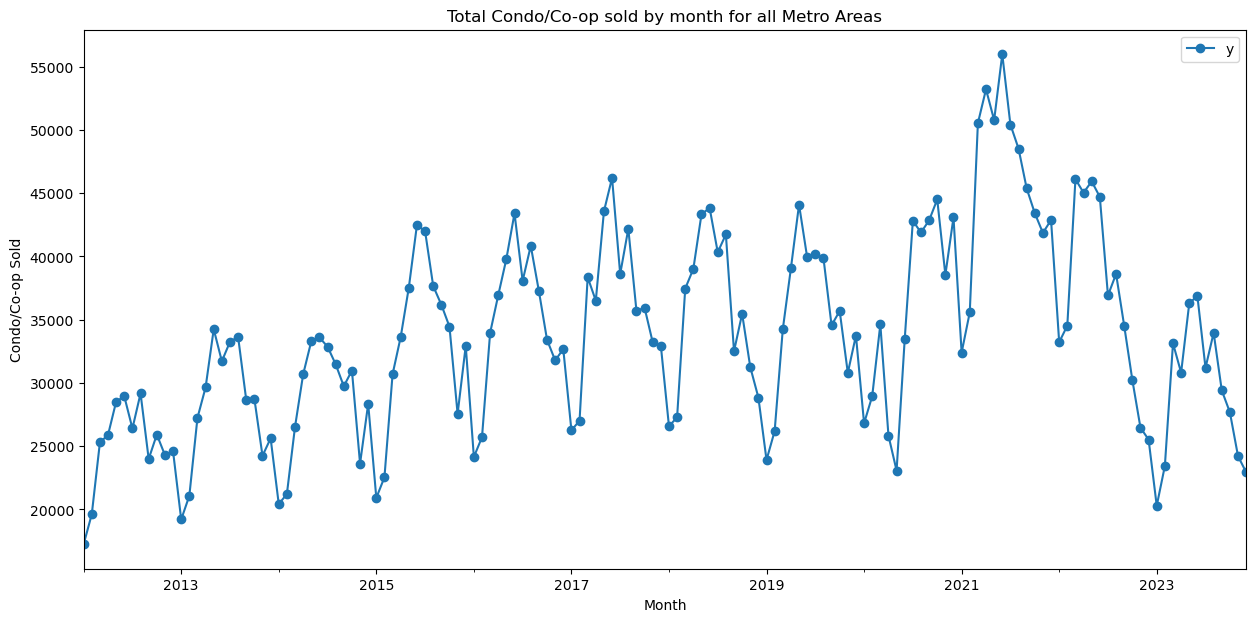

In [19]:
df_homes_condo = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Condo/Co-op']
df_homes_condo1 = df_homes_condo[['period_begin','homes_sold']].rename(columns={'period_begin':'ds','homes_sold':'y'}).sort_values(by='ds').dropna()
df_homes_condo_sum=df_homes_condo1.groupby('ds')['y'].agg(['sum']).rename(columns={'sum':'y'})
df_homes_condo_sum.plot(marker="o", figsize=(15,7))
plt.title("Total Condo/Co-op sold by month for all Metro Areas")
plt.xlabel("Month")
plt.ylabel("Condo/Co-op Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
#plt.ylim(0, max(forecast_srf['yhat_upper']))

In [20]:
prophet_condo=df_homes_condo_sum.reset_index()
m2 = Prophet()
m2.fit(prophet_condo)

20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(0.0, 55982.0)

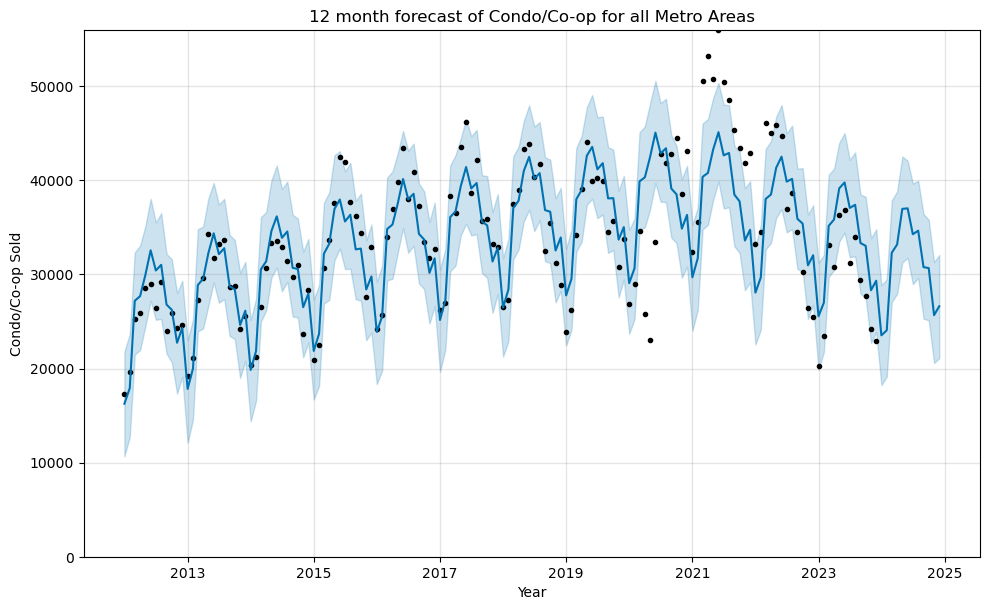

In [21]:
future_condo = m2.make_future_dataframe(periods=12, freq='M')
forecast_condo = m2.predict(future_condo)
m2.plot(forecast_condo);
plt.title("12 month forecast of Condo/Co-op for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Condo/Co-op Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(df_homes_condo_sum["y"]))

(0.0, 50576.114103945445)

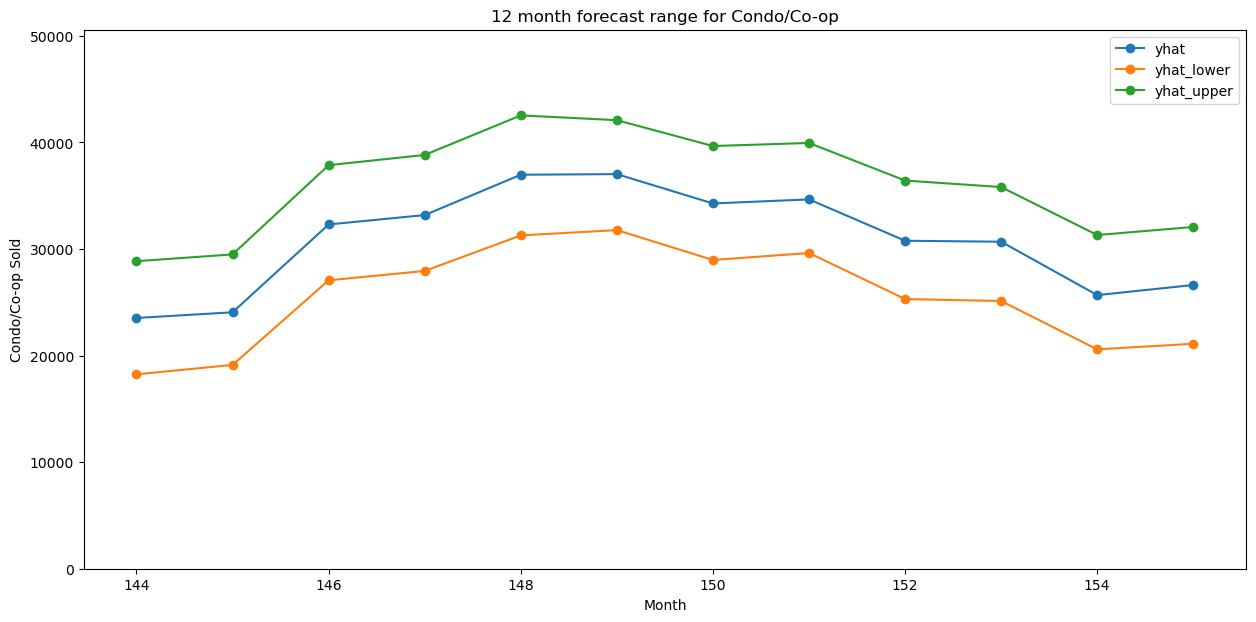

In [22]:
forecast_condo[['ds','yhat','yhat_lower','yhat_upper']]
forecast_condo[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot(marker="o", figsize=(15,7))
plt.title("12 month forecast range for Condo/Co-op")
plt.xlabel("Month")
plt.ylabel("Condo/Co-op Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(forecast_condo['yhat_upper']))

C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

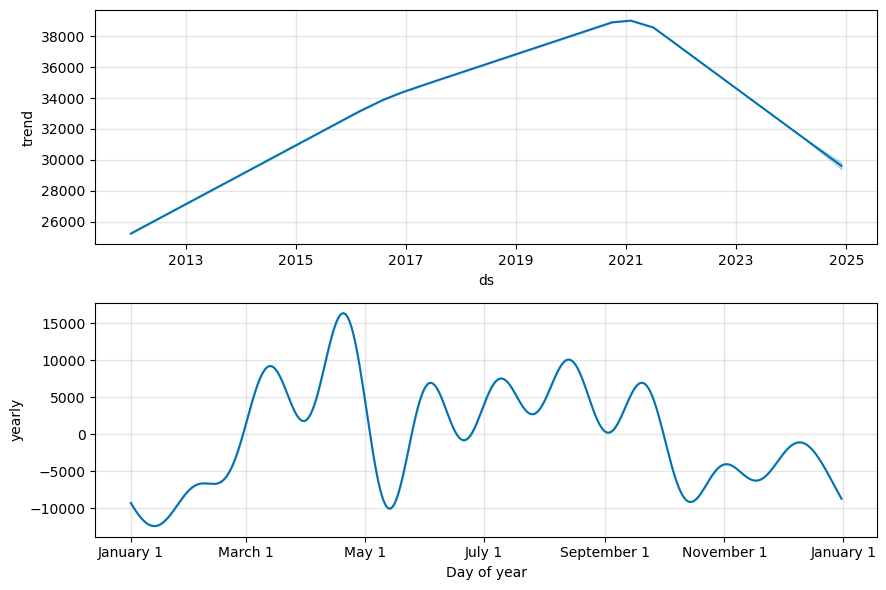

In [23]:
forecast_condo = forecast_condo.reset_index()
fig2=m2.plot_components(forecast_condo)

Text(0, 0.5, 'Townhouses Sold')

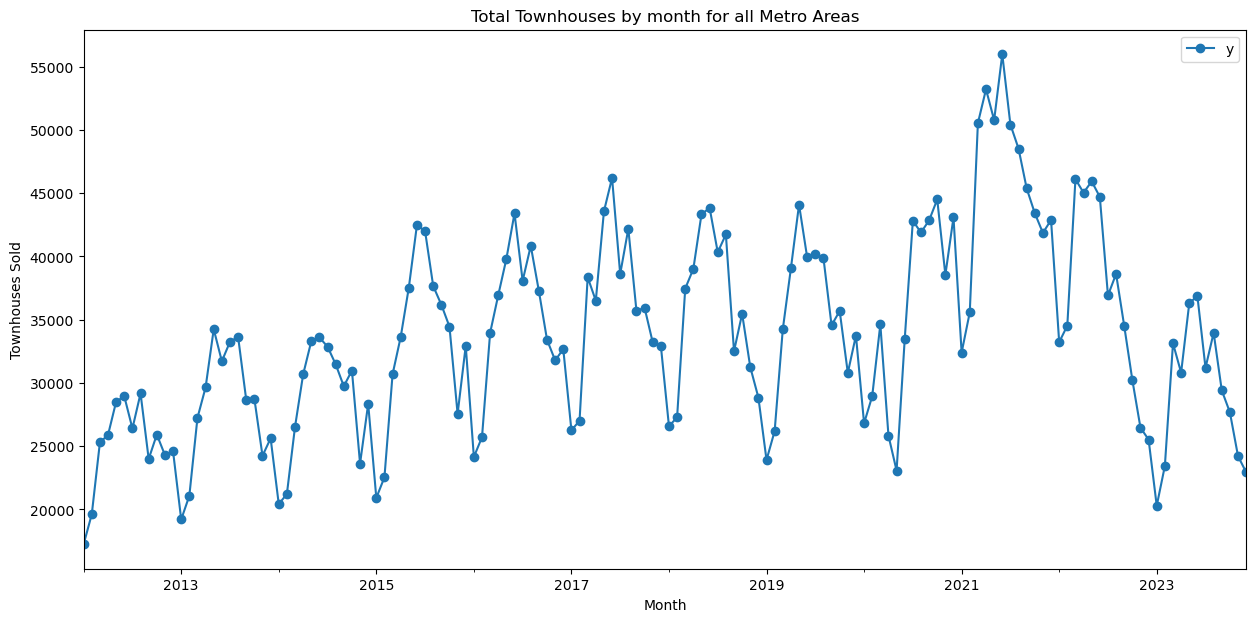

In [24]:
df_homes_townhouse = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Townhouse']
df_homes_townhouse1 = df_homes_condo[['period_begin','homes_sold']].rename(columns={'period_begin':'ds','homes_sold':'y'}).sort_values(by='ds').dropna()
df_homes_townhouse_sum=df_homes_townhouse1.groupby('ds')['y'].agg(['sum']).rename(columns={'sum':'y'})
df_homes_townhouse_sum.plot(marker="o", figsize=(15,7))
plt.title("Total Townhouses by month for all Metro Areas")
plt.xlabel("Month")
plt.ylabel("Townhouses Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
#plt.ylim(0, max(forecast_srf['yhat_upper']))

In [25]:
prophet_townhouse=df_homes_townhouse_sum.reset_index()
m4 = Prophet()
m4.fit(prophet_townhouse)

20:12:54 - cmdstanpy - INFO - Chain [1] start processing
20:12:55 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(0.0, 55982.0)

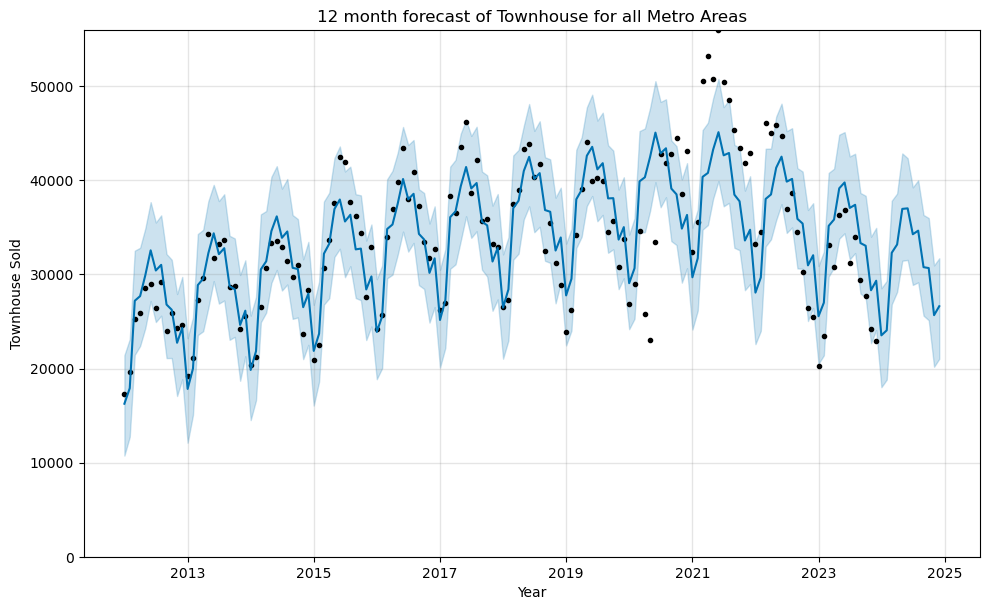

In [26]:
future_townhouse = m2.make_future_dataframe(periods=12, freq='M')
forecast_townhouse = m2.predict(future_townhouse)
m4.plot(forecast_townhouse);
plt.title("12 month forecast of Townhouse for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Townhouse Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(df_homes_townhouse_sum["y"]))

(0.0, 50772.94623841449)

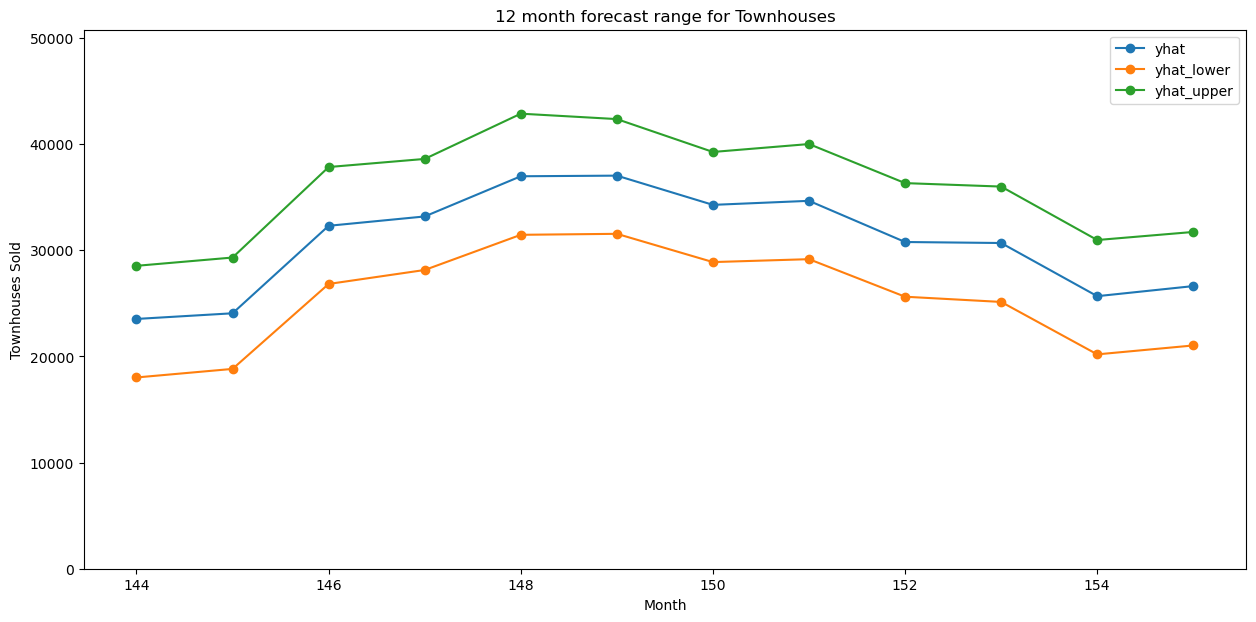

In [27]:
forecast_townhouse[['ds','yhat','yhat_lower','yhat_upper']]
forecast_townhouse[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot(marker="o", figsize=(15,7))
plt.title("12 month forecast range for Townhouses")
plt.xlabel("Month")
plt.ylabel("Townhouses Sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(forecast_townhouse['yhat_upper']))

C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

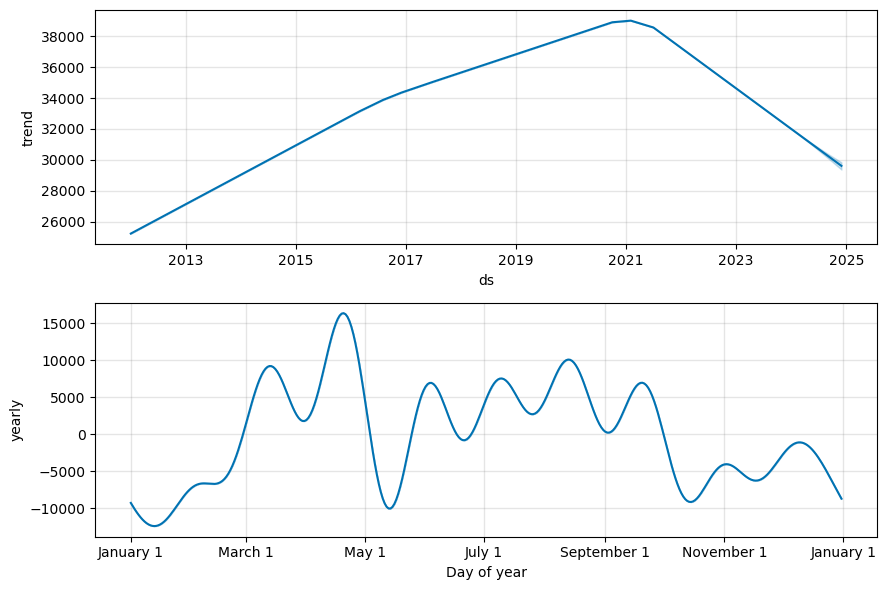

In [28]:
forecast_townhouse = forecast_townhouse.reset_index()
fig4=m4.plot_components(forecast_townhouse)

Text(0, 0.5, 'Multi-Family (2-4 Unit)')

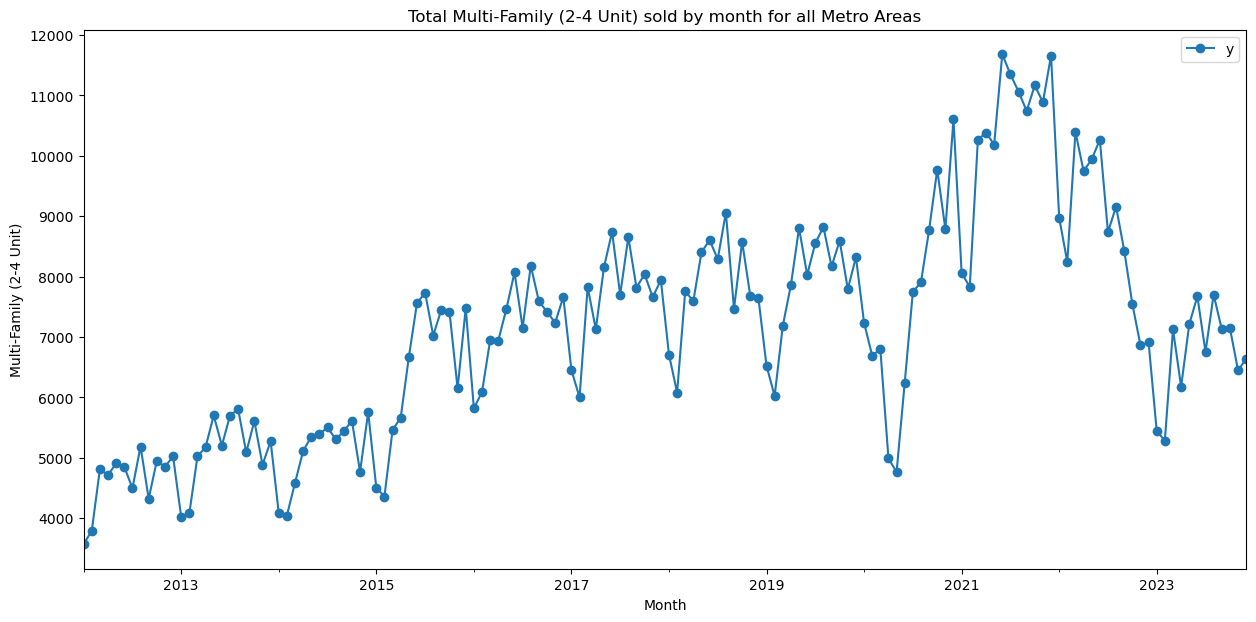

In [29]:
df_homes_multifam = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Multi-Family (2-4 Unit)']
df_homes_multifam1 = df_homes_multifam[['period_begin','homes_sold']].rename(columns={'period_begin':'ds','homes_sold':'y'}).sort_values(by='ds').dropna()
df_homes_multifam_sum=df_homes_multifam1.groupby('ds')['y'].agg(['sum']).rename(columns={'sum':'y'})
df_homes_multifam_sum.plot(marker="o", figsize=(15,7))
plt.title("Total Multi-Family (2-4 Unit) sold by month for all Metro Areas")
plt.xlabel("Month")
plt.ylabel("Multi-Family (2-4 Unit)")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
#plt.ylim(0, max(forecast_srf['yhat_upper']))

In [30]:
prophet_multifam=df_homes_multifam_sum.reset_index()
m5 = Prophet()
m5.fit(prophet_multifam)

20:13:07 - cmdstanpy - INFO - Chain [1] start processing
20:13:07 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(0.0, 11683.0)

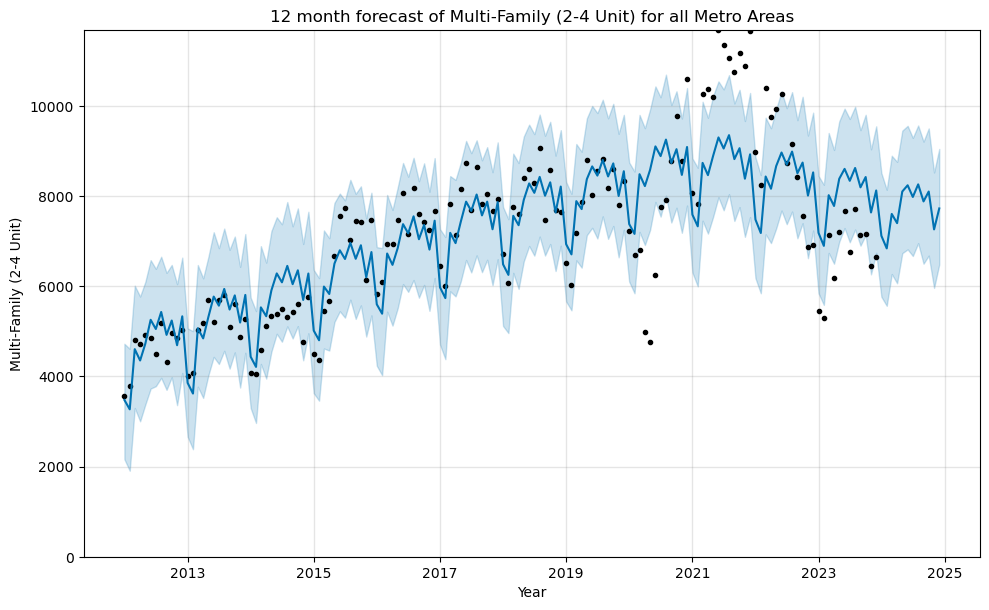

In [31]:
future_multifam = m5.make_future_dataframe(periods=12, freq='M')
forecast_multifam = m5.predict(future_multifam)
m5.plot(forecast_multifam);
plt.title("12 month forecast of Multi-Family (2-4 Unit) for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Multi-Family (2-4 Unit)")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(df_homes_multifam_sum["y"]))

(0.0, 10692.598031083806)

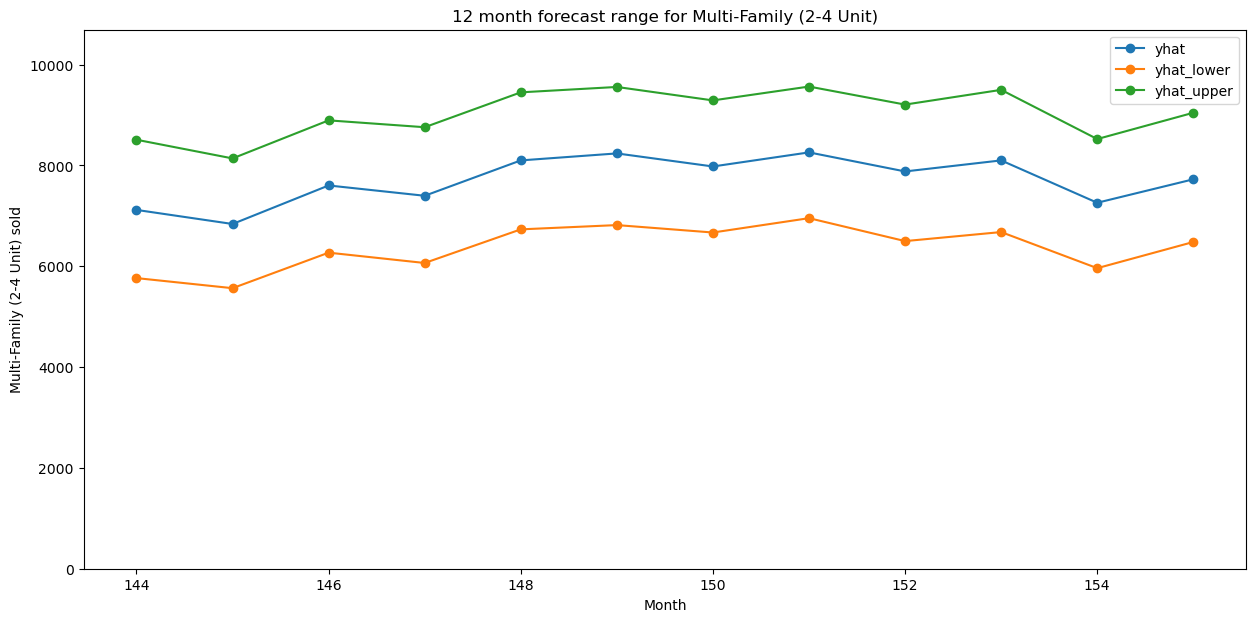

In [32]:
forecast_multifam[['ds','yhat','yhat_lower','yhat_upper']]
forecast_multifam[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot(marker="o", figsize=(15,7))
plt.title("12 month forecast range for Multi-Family (2-4 Unit)")
plt.xlabel("Month")
plt.ylabel("Multi-Family (2-4 Unit) sold")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(0, max(forecast_multifam['yhat_upper']))

C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

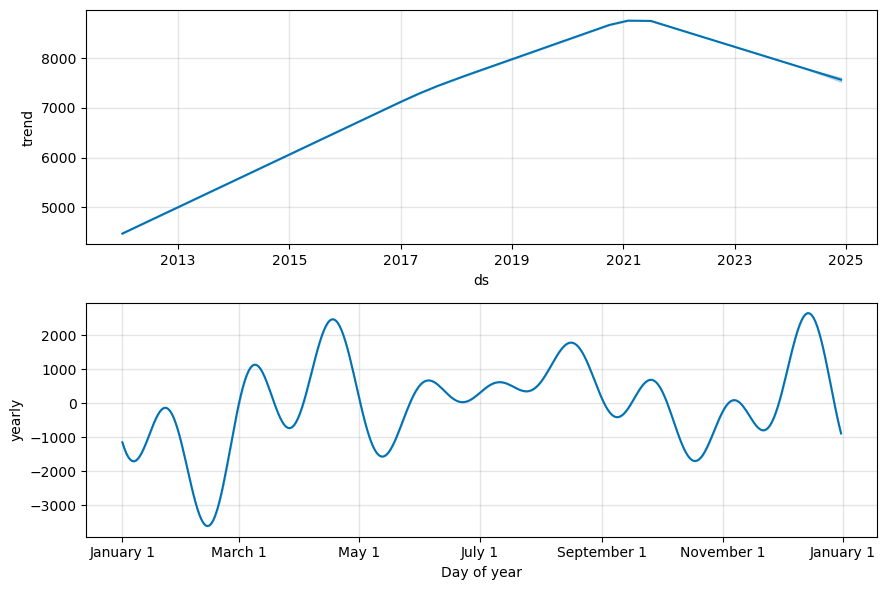

In [33]:
forecast_multifam = forecast_multifam.reset_index()
fig5=m5.plot_components(forecast_multifam)

Text(0, 0.5, 'Single Family Residential homes')

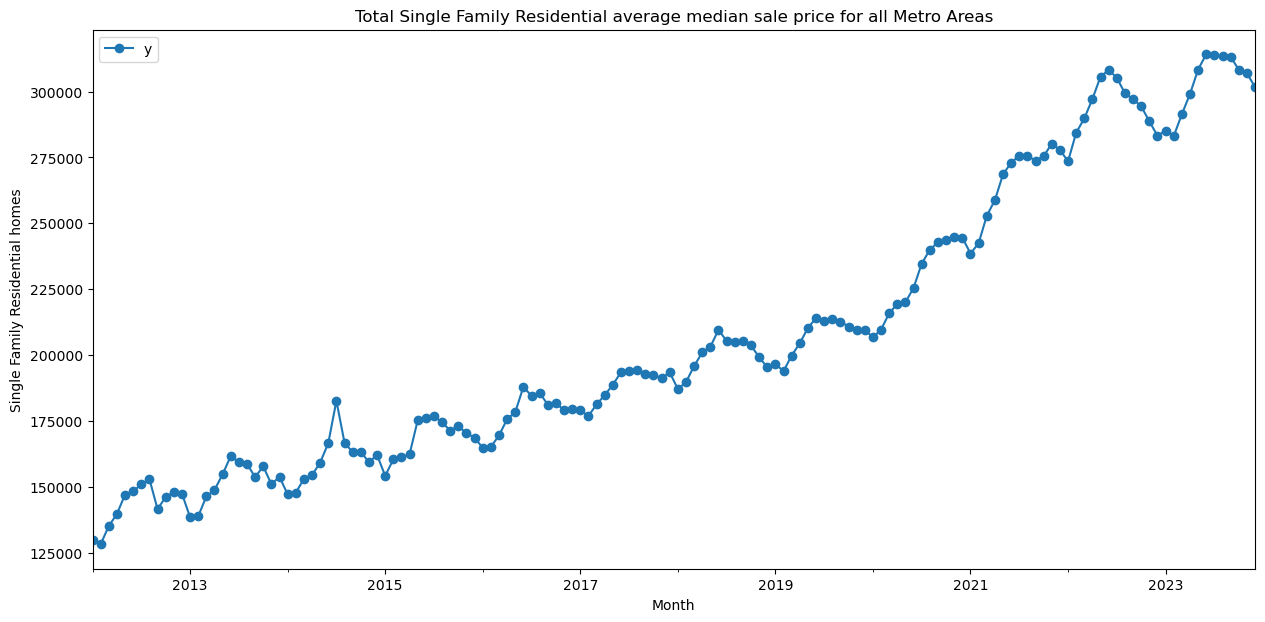

In [42]:
df_homes_srf_sales = df_homes_forecast.loc[df_homes_forecast['property_type'] == 'Single Family Residential']
df_homes_srf_sales1 = df_homes_srf_sales[['period_begin','median_sale_price']].rename(columns={'period_begin':'ds','median_sale_price':'y'}).sort_values(by='ds').dropna()
df_homes_srf_sales_sum=df_homes_srf_sales1.groupby('ds')['y'].agg(['mean']).rename(columns={'mean':'y'})
df_homes_srf_sales_sum.plot(marker="o", figsize=(15,7))
plt.title("Total Single Family Residential average median sale price for all Metro Areas")
plt.xlabel("Month")
plt.ylabel("Single Family Residential homes")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
#plt.ylim(0, max(forecast_srf['yhat_upper']))


In [43]:
df_homes_srf_sales_sum

,y
ds,
2012-01-01,129632.206015
2012-02-01,128206.760324
2012-03-01,135103.667622
2012-04-01,139675.205580
2012-05-01,147020.298258
...,...
2023-08-01,313376.375817
2023-09-01,313135.635417
2023-10-01,308303.351262


In [44]:
prophet_srf_sales=df_homes_srf_sales_sum.reset_index()
m3 = Prophet()
m3.fit(prophet_srf_sales)

20:20:30 - cmdstanpy - INFO - Chain [1] start processing
20:20:31 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(100000.0, 344154.6575492341)

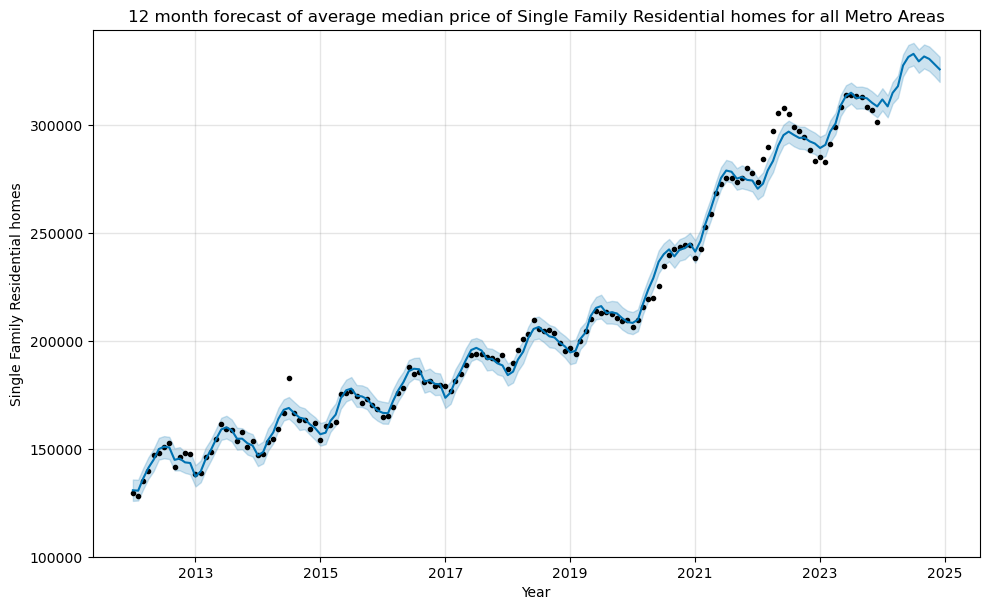

In [56]:
future_srf_sales = m3.make_future_dataframe(periods=12, freq='M')
forecast_srf_sales = m3.predict(future_srf_sales)
m3.plot(forecast_srf_sales);
plt.title("12 month forecast of average median price of Single Family Residential homes for all Metro Areas")
plt.xlabel("Year")
plt.ylabel("Single Family Residential homes")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(100000, max(prophet_srf_sales["y"])+ 30000)

In [51]:
forecast_srf_sales.tail(12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
144,2023-12-31,316147.504397,306868.397640,317461.728360,316147.504397,316147.504397,-4179.221133,-4179.221133,-4179.221133,-4179.221133,-4179.221133,-4179.221133,0.0,0.0,0.0,311968.283264
145,2024-01-31,317677.143103,303743.705576,314075.547640,317609.423188,317757.004603,-8929.771856,-8929.771856,-8929.771856,-8929.771856,-8929.771856,-8929.771856,0.0,0.0,0.0,308747.371247
146,2024-02-29,319108.095440,309679.658080,319972.836525,318904.449827,319311.954297,-4103.363920,-4103.363920,-4103.363920,-4103.363920,-4103.363920,-4103.363920,0.0,0.0,0.0,315004.731520
147,2024-03-31,320637.734145,312855.166493,323172.255906,320265.760545,321055.014013,-2545.797915,-2545.797915,-2545.797915,-2545.797915,-2545.797915,-2545.797915,0.0,0.0,0.0,318091.936231
148,2024-04-30,322118.029666,322916.625377,333349.292940,321553.465615,322777.209610,5615.036335,5615.036335,5615.036335,5615.036335,5615.036335,5615.036335,0.0,0.0,0.0,327733.066001
149,2024-05-31,323647.668372,326378.066872,337015.633407,322866.957405,324571.721310,8031.235887,8031.235887,8031.235887,8031.235887,8031.235887,8031.235887,0.0,0.0,0.0,331678.904259
150,2024-06-30,325127.963893,327884.231355,338549.163695,324083.098198,326312.839430,7967.115922,7967.115922,7967.115922,7967.115922,7967.115922,7967.115922,0.0,0.0,0.0,333095.079815
151,2024-07-31,326657.602598,324236.143756,335059.049095,325334.602452,328108.242560,2948.353869,2948.353869,2948.353869,2948.353869,2948.353869,2948.353869,0.0,0.0,0.0,329605.956467
152,2024-08-31,328187.241304,326320.118595,337193.681798,326564.773775,329955.326502,3706.422229,3706.422229,3706.422229,3706.422229,3706.422229,3706.422229,0.0,0.0,0.0,331893.663533
153,2024-09-30,329667.536825,324922.091358,336703.052618,327705.620267,331872.625019,1080.886715,1080.886715,1080.886715,1080.886715,1080.886715,1080.886715,0.0,0.0,0.0,330748.423540


(250000.0, 368549.16369502165)

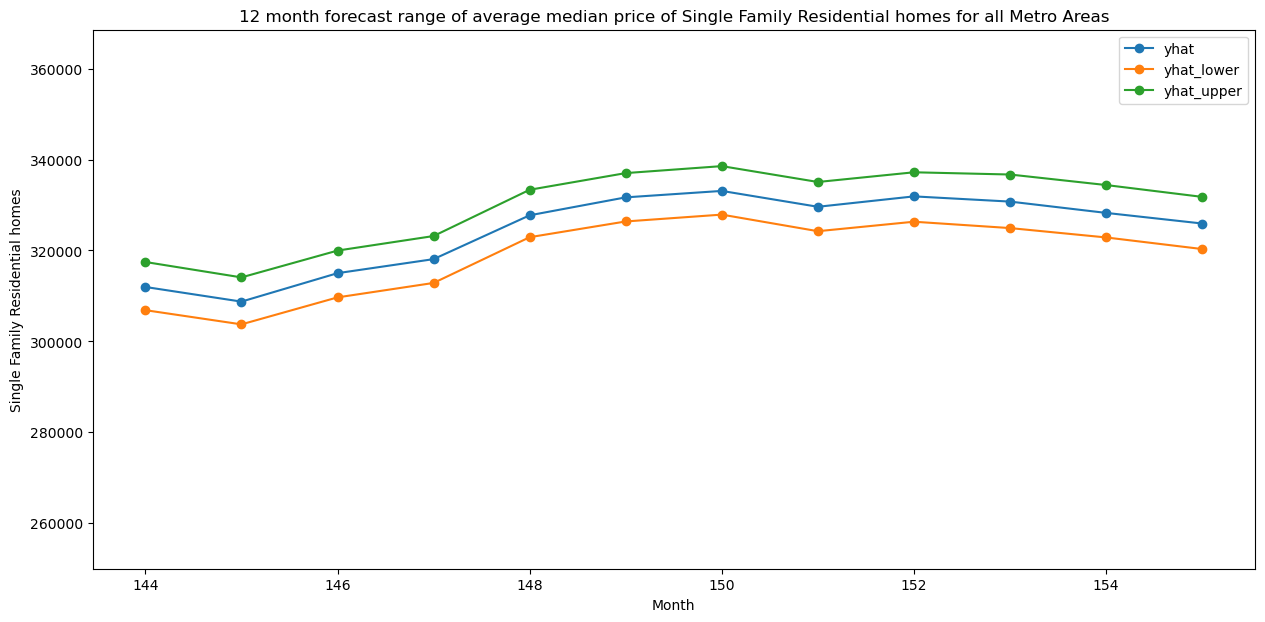

In [55]:
forecast_srf_sales[['ds','yhat','yhat_lower','yhat_upper']]
forecast_srf_sales[['yhat','yhat_lower','yhat_upper']].iloc[-12:,:].plot(marker="o", figsize=(15,7))
plt.title("12 month forecast range of average median price of Single Family Residential homes for all Metro Areas")
plt.xlabel("Month")
plt.ylabel("Single Family Residential homes")
#plt.xlim(-0.25, len(df_homes_srf_sum["ds"]))
plt.ylim(250000, max(forecast_srf_sales['yhat_upper'])+ 30000)

C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\Kothapallis\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python d

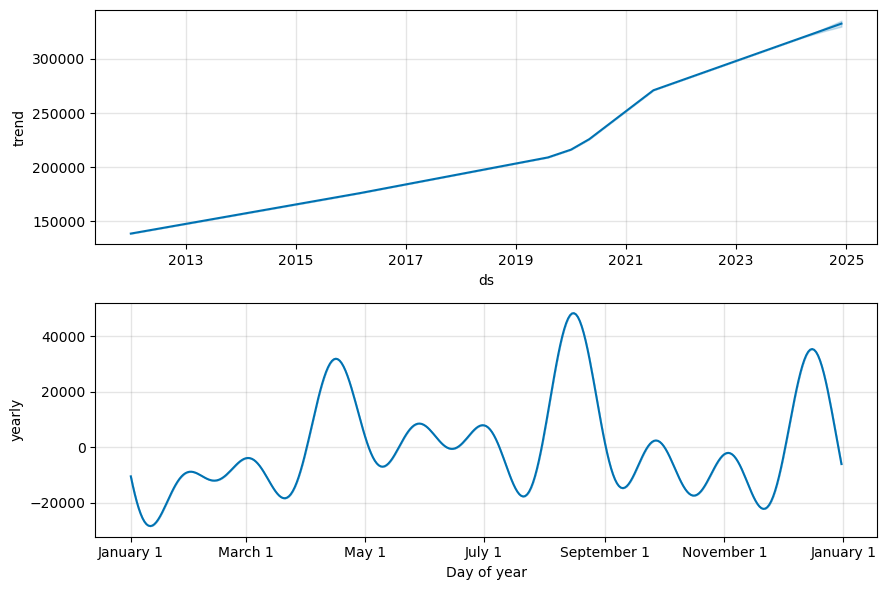

In [58]:
forecast_srf_sales = forecast_srf_sales.reset_index()
fig3=m3.plot_components(forecast_srf_sales)